# 금융데이터베이스 Group 7 기말프로젝트

* 20249032	곽기은	klutzduck@kaist.ac.kr
* 20249124	김태훈	thk24@kaist.ac.kr
* 20249197	서승건	seanseo@kaist.ac.kr
* 20249366	장우석	expressj@kaist.ac.kr
* 20249402	조영민	youngmin.cho@kaist.ac.kr
* 20249459	홍성수	seongsu.hong@kaist.ac.kr

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from pandas.tseries.offsets import MonthEnd, YearEnd
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from pathlib import Path

# https://ecos.bok.or.kr/api/#/DevGuide/DevSpeciflcation
# SSL 보안 장비 등으로 인해 SSL Verification Error가 발생할 경우에 대비해서 requests.get할 때 verify = False하고, warning을 무시하도록 설정한다.
# SSL Verification을 끈다.
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# 한국은행 API를 사용하기 위한 인증정보를 설정한다.
BOK_API_URL = 'https://ecos.bok.or.kr/api'
BOK_API_KEY = 'W2HQL3IHAD2LKU409JDH'

## Convert to monthly observations
### End-of-month observation

In [3]:
df_xr = pd.read_excel(Path('data/krw_jpy_xr.xlsx'))
df_xr = df_xr.set_index('date')
df_monthly = df_xr.resample('ME').last()
df_monthly['ret'] = df_monthly['KRW/JPY'].pct_change() * 100
df_monthly = df_monthly.dropna()
df_monthly.head(3)

,KRW/JPY,ret
date,,
1977-05-31,174.67,0.223778
1977-06-30,180.11,3.114444
1977-07-31,181.95,1.021598


## 환율 변화율을 예측하기

### IMF 이전 환율정책:

* IMF 외환위기 이전 한국은 '관리변동환율제'를 채택하고 있었습니다.
* 이 제도 하에서 정부는 환율의 일일 변동폭을 제한하고, 외환시장에 직접 개입하여 환율을 관리했습니다.


### IMF 이후 환율정책:

* 1997년 12월 IMF 구제금융을 받으면서 한국은 '자유변동환율제'로 전환했습니다.
* 이 제도에서는 원칙적으로 시장의 수요와 공급에 따라 환율이 결정됩니다.
* 정부의 직접적인 시장 개입은 크게 줄어들었습니다

### 아베노믹스 (2012년~): 2012년 12월 26일

* 영향력: 매우 큼
* 지속기간: 장기적 (수년간 지속)
* 직접성: 엔화 환율에 직접적인 영향
* 의도성: 의도적인 엔화 약세 정책

### 아베노믹스는 일본 경제 회복을 위해 의도적으로 엔화 가치를 낮추는 정책을 포함했습니다. 
### 이로 인해 엔화 가치가 급격히 하락했고, 원/엔 환율에 지속적이고 큰 영향을 미쳤습니다.

In [5]:
df_monthly = df_monthly.loc['2012-12-26':]

X = df_monthly.iloc[:-1]['ret']
X = sm.add_constant(X)
Y = df_monthly.iloc[1:]['ret']

sm.OLS(Y, X.values).fit().summary()

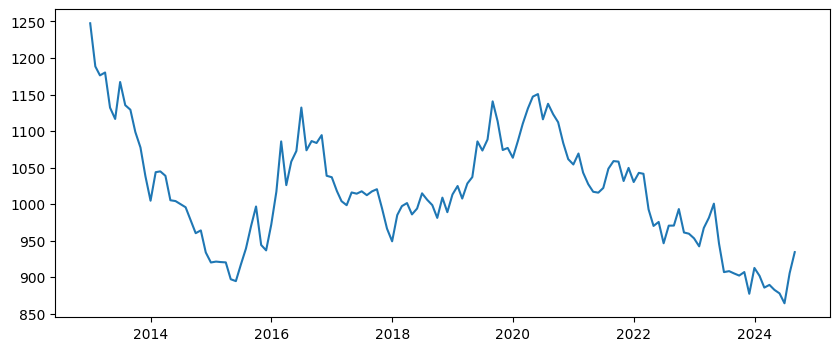

In [7]:
plt.rcParams['figure.figsize'] = (10, 4)
plt.plot(df_monthly['KRW/JPY'])
plt.show()

In [8]:
df_real_xr = pd.read_excel(Path('data/world_real_xr.xls'), sheet_name = 'Data', skiprows = 3)
df_real_xr = df_real_xr.set_index('Country Code')

In [9]:
df_real_xr_kor = df_real_xr.loc['KOR'].to_frame()
df_real_xr_kor = df_real_xr_kor.iloc[3:]
df_real_xr_kor = df_real_xr_kor.dropna()
df_real_xr_kor['KOR'] = df_real_xr_kor['KOR'].astype(float)
df_real_xr_kor['date'] = pd.to_datetime(df_real_xr_kor.index) + YearEnd()
df_real_xr_kor = df_real_xr_kor.set_index('date')
df_real_xr_kor.columns = ['KOR Real XR']
df_real_xr_kor.head(3)

,KOR Real XR
date,
1990-12-31,0.791111
1991-12-31,0.806041
1992-12-31,0.797916


In [10]:
df_real_xr_jpn = df_real_xr.loc['JPN'].to_frame()
df_real_xr_jpn = df_real_xr_jpn.iloc[3:]
df_real_xr_jpn = df_real_xr_jpn.dropna()
df_real_xr_jpn['JPN'] = df_real_xr_jpn['JPN'].astype(float)
df_real_xr_jpn['date'] = pd.to_datetime(df_real_xr_jpn.index) + YearEnd()
df_real_xr_jpn = df_real_xr_jpn.set_index('date')
df_real_xr_jpn.columns = ['JPN Real XR']
df_real_xr_jpn.head(3)

,JPN Real XR
date,
1990-12-31,1.295738
1991-12-31,1.386324
1992-12-31,1.465824


In [11]:
# 기존의 KOR와 JPN 데이터프레임을 합칩니다
df_combined = pd.concat([df_real_xr_kor, df_real_xr_jpn], axis = 1)

# KRW/JPY 실질환율 계산
# KRW/USD를 JPY/USD로 나눈다.
df_combined['KRW/JPY Real XR'] = df_combined['KOR Real XR'] / (df_combined['JPN Real XR'])

# 결과 확인
df_combined.tail(3)

,KOR Real XR,JPN Real XR,KRW/JPY Real XR
date,,,
2021-12-31,0.723172,0.899195,0.804244
2022-12-31,0.627537,0.721953,0.869221
2023-12-31,0.612982,0.673903,0.909600


In [12]:
df_real_xr = df_combined['KRW/JPY Real XR']

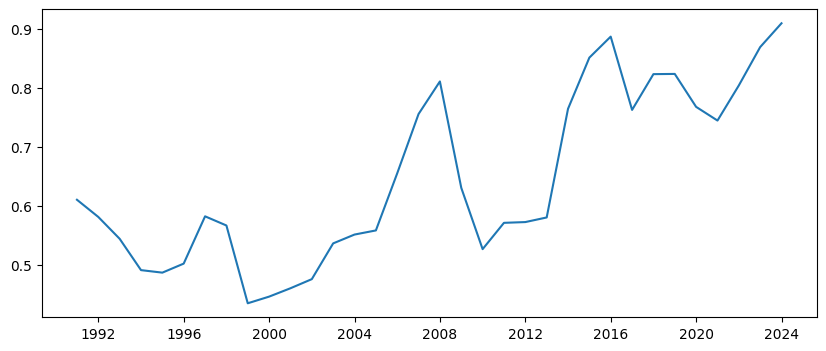

In [13]:
plt.plot(df_real_xr)
plt.show()

## Overlapping monthly forecasts

In [14]:
df_monthly = df_monthly.drop('ret', axis = 1)
df_merged = df_monthly.join(df_real_xr)
# ffill - forward fill
# bfill - backward fill
df_merged['KRW/JPY Real XR'] = df_merged['KRW/JPY Real XR'].ffill()

df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100

df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

df_merged.head(15)


,KRW/JPY,KRW/JPY Real XR,ann_ret,F12.ann_ret
date,,,,
2012-12-31,1247.50,0.580543,NaN,-19.466132
2013-01-31,1188.47,0.580543,NaN,-12.180366
2013-02-28,1176.20,0.580543,NaN,-11.169869
2013-03-31,1180.13,0.580543,NaN,-11.981731
2013-04-30,1132.04,0.580543,NaN,-11.194834
2013-05-31,1116.58,0.580543,NaN,-10.066453
2013-06-30,1167.15,0.580543,NaN,-14.321210
2013-07-31,1135.40,0.580543,NaN,-12.302272
2013-08-31,1129.19,0.580543,NaN,-13.426438


### Use OLS to fit the forecast model

In [15]:
df = df_merged[['KRW/JPY Real XR', 'F12.ann_ret']]
df = df.dropna()

In [16]:
X = df['KRW/JPY Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

sm.OLS(Y, X).fit().summary()

## Real XR 대신 PPP XR 활용하기

In [18]:
def load_world_bank_data(filepath, country, column):
    df = pd.read_excel(filepath, sheet_name = 'Data', skiprows = 3)

    df = df.set_index('Country Code')
    df = df.loc[country].to_frame()
    df = df.iloc[3:]
    df = df.dropna()
    df = df.astype(float)
    
    df['date'] = pd.to_datetime(df.index) + YearEnd()
    df = df.set_index('date')
    df.columns = [column]
    
    return df

In [19]:
df_ppp_xr_kor = load_world_bank_data(Path('data/world_ppp_xr.xls'), 'KOR', 'PPP XR')
df_ppp_xr_jpn = load_world_bank_data(Path('data/world_ppp_xr.xls'), 'JPN', 'PPP XR')

In [20]:
df_ppp_combined = pd.concat([df_ppp_xr_kor, df_ppp_xr_jpn], axis = 1)
df_ppp_combined.columns = ['KOR PPP XR', 'JPN PPP XR']
df_ppp_combined['KRW/JPY PPP XR'] = df_ppp_combined['KOR PPP XR'] / (df_ppp_combined['JPN PPP XR'])
df_ppp_xr = df_ppp_combined.drop(['KOR PPP XR', 'JPN PPP XR'], axis = 1)

In [21]:
df_ppp_xr.head(3)

,KRW/JPY PPP XR
date,
1990-12-31,2.984441
1991-12-31,3.165311
1992-12-31,3.355232


### Merge with monthly observations

In [22]:
df_merged = df_monthly.join(df_real_xr)
df_merged = df_merged.join(df_ppp_xr)
df_merged.head(3)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR
date,,,
2012-12-31,1247.50,0.580543,8.198472
2013-01-31,1188.47,NaN,NaN
2013-02-28,1176.20,NaN,NaN


### Compute Real XR

In [23]:
df_merged['KRW/JPY PPP XR'] = df_merged['KRW/JPY PPP XR'].ffill()
df_merged.head(3)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR
date,,,
2012-12-31,1247.50,0.580543,8.198472
2013-01-31,1188.47,NaN,8.198472
2013-02-28,1176.20,NaN,8.198472


In [24]:
df_merged['New Real XR'] = df_merged['KRW/JPY PPP XR'] / df_merged['KRW/JPY'] * 100
df_merged.tail(3)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR,New Real XR
date,,,,
2024-06-30,864.31,NaN,8.453422,0.978054
2024-07-31,905.44,NaN,8.453422,0.933626
2024-08-31,934.32,NaN,8.453422,0.904767


In [25]:
df_merged['KRW/JPY Real XR'] = df_merged['KRW/JPY Real XR'].ffill()

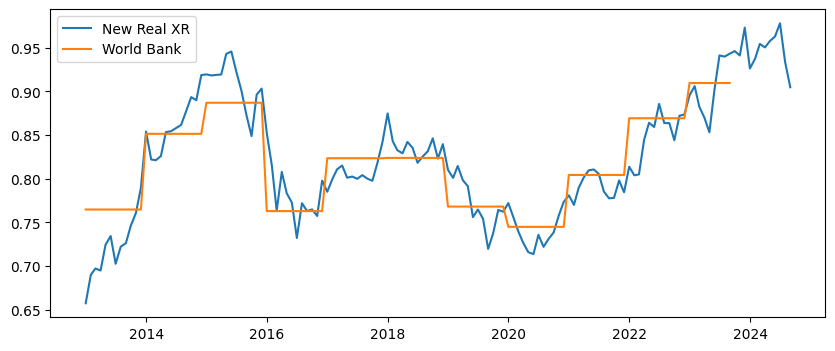

In [26]:
plt.plot(df_merged['New Real XR'], label='New Real XR')
plt.plot(df_merged['KRW/JPY Real XR'].shift(-12), label='World Bank')
plt.legend()
plt.show()

## Compute annual XR return

In [27]:
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)
df_merged.head(5)

,KRW/JPY,KRW/JPY Real XR,KRW/JPY PPP XR,New Real XR,ann_ret,F12.ann_ret
date,,,,,,
2012-12-31,1247.50,0.580543,8.198472,0.657192,NaN,-19.466132
2013-01-31,1188.47,0.580543,8.198472,0.689834,NaN,-12.180366
2013-02-28,1176.20,0.580543,8.198472,0.697030,NaN,-11.169869
2013-03-31,1180.13,0.580543,8.198472,0.694709,NaN,-11.981731
2013-04-30,1132.04,0.580543,8.198472,0.724221,NaN,-11.194834


### Use OLS to fit the forecast model

In [29]:
df = df_merged[['New Real XR', 'F12.ann_ret']]
df = df.dropna()

X = df['New Real XR']
X = sm.add_constant(X)
Y = df['F12.ann_ret']

sm.OLS(Y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            F12.ann_ret   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     52.98
Date:                Sun, 11 Aug 2024   Prob (F-statistic):           3.10e-11
Time:                        10:57:36   Log-Likelihood:                -432.56
No. Observations:                 129   AIC:                             869.1
Df Residuals:                     127   BIC:                             874.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -59.1016      7.884     -7.496      0.000     -74.703     -43.500
New Real XR    70.3263      9.661      7.279      0.000      51.208      89.445
==============================================================================
Omnibus:                        4.320   Durbin-Watson:                   0.146
Prob(Omnibus):                  0.115   Jarque-Bera (JB):                3.365
Skew:                           0.273   Prob(JB):                        0.186
Kurtosis:                       2.428   Cond. No.                         26.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Predict XR

In [ ]:
last_obs = df_merged.iloc[-1]
last_obs

In [ ]:
last_xr = last_obs['KRW/JPY']
last_real_xr = last_obs['New Real XR']

In [ ]:
last_xr

In [ ]:
last_real_xr

### OLS 결과 그대로 사용하여 예측

In [ ]:
#exogeneous variables
exog = [1, last_real_xr]
results.predict(exog = exog)

### Confidence Interval

In [ ]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        iv_l[0],
        iv_u[0],
    ))

### 환율 예측하기

In [ ]:
pred_ret = results.predict(exog = exog)
last_xr * (1 + pred_ret[0] / 100)

In [ ]:
for alpha in [0.05, 0.25, 0.50]:
    prstd, iv_l, iv_u = wls_prediction_std(results, exog = exog, alpha = alpha)
    
    print('Confidence interval at alpha = {:.2f}: {:.2f} ~ {:.2f}'.format(
        alpha,
        last_xr * (1 + iv_l[0] / 100),
        last_xr * (1 + iv_u[0] / 100),
    ))

## 추가 지표 획득

In [ ]:
def fetch_bok_data(service_code, stat_code=None, item=None):
    url = f"{BOK_API_URL}/{service_code}/{BOK_API_KEY}/json/kr/1/100000"
    
    if item is not None:
        url += "/{}/{}/{}/{}/{}".format(item['STAT_CODE'], item['CYCLE'], item['START_TIME'], item['END_TIME'], item['ITEM_CODE'])
        
        if type(item['ITEM_CODE2']) is str:
            url += f"/{item['ITEM_CODE2']}"
        
    elif stat_code is not None:
        url += f"/{stat_code}"
    
    print(url)
    
    resp = requests.get(url, verify = False)
    results = resp.json()
    rows = results[service_code]['row']
    df = pd.DataFrame(rows)
    
    return df

In [ ]:
TARGET_STAT_CODES = [
    '731Y001',  # 3.1.1.1. 주요국 통화의 대원화환율
    '902Y008',  # 9.1.2.2. 국제 주요국 소비자물가지수
    '902Y009',  # 9.1.3.1. 국제 주요국 경상수지
    '902Y015',  # 9.1.4.1. 국제 주요국 경제성장률
    '902Y016',  # 9.1.4.2. 국제 주요국 국내총생산(GDP)
    '902Y023',  # 9.1.6.1. 주요국제금리
    '817Y002',  # 1.3.2.1. 시장금리(일별)
    '732Y001',  # 3.5. 외환보유액
]

In [ ]:
dfs = []

for stat_code in TARGET_STAT_CODES:
    df = fetch_bok_data('StatisticItemList', stat_code = stat_code)
    
    dfs.append(df)

In [ ]:
df_item_codes = pd.concat(dfs, axis = 0)

In [ ]:
df_item_codes.to_excel(Path('data/bok_item_codes.xlsx'), index = False)

In [ ]:
df_item_codes = df_item_codes.set_index(['STAT_CODE', 'ITEM_CODE', 'CYCLE'])

### Download data values

In [ ]:
data_download_list = pd.read_excel(Path('data/bok_data_download_list_jpy.xlsx'))

In [ ]:
data_download_list

In [ ]:
#iterate over row
for idx, row in data_download_list.iterrows():
    name = row['name']
    print(f"Downloading {name}...")
    
    idx = (row.STAT_CODE, row.ITEM_CODE, row.CYCLE)
    item = df_item_codes.loc[idx]
    item ={**item, **row}
    
    df = fetch_bok_data('StatisticSearch', item = item)
    df = df[['TIME', 'DATA_VALUE']]
    
    if row['CYCLE'] == 'D':
        df['date'] = pd.to_datetime(df['TIME'])
    
    elif row['CYCLE'] == 'M':
        df['date'] = pd.to_datetime(df['TIME'], format = '%Y%m') + MonthEnd()
    
    elif row['CYCLE'] == 'Q':
        df['year'] = df['TIME'].str[:4]
        df['month'] = df['TIME'].str[-1].astype(int) * 3
        df['day'] = 1
        df['date'] = pd.to_datetime(df[['year', 'month', 'day']]) + MonthEnd()
    
    elif row['CYCLE'] == 'A':
        df['date'] = pd.to_datetime(df['TIME']) + YearEnd()
    
    else:
        raise RuntimeError()
        
    df = df[['date','DATA_VALUE']]
    df = df.rename(columns={'DATA_VALUE': name, })
    
    df[name] = df[name].astype(float)
    
    df.to_excel(Path(f"data/{name}.xlsx"), index = False)
    
print('** Completed!! **')

## BOK 파일 불러오기

In [ ]:
filenames = [
    'krw_jpy_xr',
    'current_account_korea',
    'current_account_us',
    'current_account_jp',
    'gdp_korea',
    'gdp_us',
    'gdp_jp',
    'gdp_growth_korea',
    'gdp_growth_jp',
    'gdp_growth_us',
    'cpi_korea',
    'cpi_jp',
    'cpi_us',
    'int_rate_korea',
    'int_rate_jp',
    'int_rate_us',
    'foreign_reserves',
]

In [ ]:
dfs = []

for fname in filenames:
    print(f"Loding {fname}....")
    
    df = pd.read_excel(Path(f"data/{fname}.xlsx"))
    df = df.set_index('date')
    
    if fname in ['gdp_growth_korea',
        'gdp_growth_jp',
        'gdp_growth_us',
        'current_account_us',
        'current_account_jp',
        'current_account_korea',
                ]:
        df[fname] = df[fname].rolling(4).sum()
    
    dfs.append(df)
    
print('** Completed **')

### World Bank 데이터로 계산했었던 KOR/JPY PPP XR 불러오기

In [ ]:
dfs.append(df_ppp_xr)

## Merge the datasets

In [ ]:
df_merged = pd.concat(dfs, axis = 1)
df_merged = df_merged.resample('ME').last()
df_merged = df_merged.ffill()
df_merged.loc['2010-01-01':].head()

# >>반영할 수 있는 지표들

### 환율 수익률

In [ ]:
df_merged['ann_ret'] = df_merged['KRW/JPY'].pct_change(periods = 12) * 100
df_merged['F12.ann_ret'] = df_merged['ann_ret'].shift(-12)

### Real XR

In [ ]:
df_merged['real_xr'] = df_merged['KRW/JPY PPP XR'] / df_merged['KRW/JPY']

### Current accounts(경상수지) relative to GDP

In [ ]:
df_merged['ca_gdp_korea'] = df_merged['current_account_korea'] / df_merged['gdp_korea'] * 100
df_merged['ca_gdp_jp'] = df_merged['current_account_jp'] / df_merged['gdp_jp'] * 100

In [ ]:
df_merged.loc['2012-12-26':][['ca_gdp_korea', 'ca_gdp_jp']].head(3)

In [ ]:
#stationary process

plt.plot(df_merged.loc['2012-12-26':]['ca_gdp_korea'], label = 'ca_gdp_korea')
#plt.plot(df_merged['ca_gdp_korea'], label = 'ca_gdp_korea')
plt.plot(df_merged.loc['2012-12-26':]['ca_gdp_jp'], label = 'ca_gdp_jp')
#plt.plot(df_merged['ca_gdp_jp'], label = 'ca_gdp_jp')
plt.legend()
plt.show()

### GDP Growth

In [ ]:
df_merged['gdp_growth_korea2'] = df_merged['gdp_korea'].pct_change(periods = 12) * 100
df_merged['gdp_growth_jp2'] = df_merged['gdp_jp'].pct_change(periods = 12) * 100

In [ ]:
df_merged.loc[['2018-12-31', '2019-12-31']][['gdp_jp', 'gdp_growth_jp', 'gdp_growth_jp2']]

### Inflation (YoY, Y/Y)

In [ ]:
df_merged['infl_korea'] = df_merged['cpi_korea'].pct_change(periods = 12) * 100
df_merged['infl_jp'] = df_merged['cpi_jp'].pct_change(periods = 12) * 100

### 상대적 인플레이션 & 금리 차이

In [ ]:
df_merged['infl_diff'] = df_merged['infl_korea'] - df_merged['infl_jp']
df_merged['int_rate_diff'] = df_merged['int_rate_korea'] - df_merged['int_rate_jp']

### GDP 대비 외환보유액 및 증가율

In [ ]:
df_merged['reserves_to_gdp'] = df_merged['foreign_reserves'] / df_merged['gdp_korea'] / 1000 * 100
df_merged['reserves_growth'] = df_merged['foreign_reserves'].pct_change(periods = 12) * 100

### 필요한 컬럼만 남김

In [ ]:
df_sample = df_merged[[
    'F12.ann_ret', 'real_xr',
    'ca_gdp_korea', 'ca_gdp_jp',
    'gdp_growth_korea', 'gdp_growth_jp',
    'infl_diff', 'int_rate_diff',
    'reserves_to_gdp', 'reserves_growth'
]]

In [ ]:
df_sample = df_sample.dropna()
df_sample = df_sample.loc['1998-12-31':]

In [ ]:
df_sample.head(3)

In [ ]:
corr = df_sample.corr()
# triu = upper triangle
mask = np.triu(np.ones_like(corr))
cmap=sns.diverging_palette(230, 20, as_cmap = True)
mask=np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmin = -1, vmax = 1)
plt.show()

In [ ]:
df_sample

In [ ]:
X = df_sample
X = sm.add_constant(X)
Y = df_sample['F12.ann_ret']

sm.OLS(Y,X).fit().summary()